<a href="https://colab.research.google.com/github/alexandrgsv/stock_prediction_models/blob/main/MMVB_LSTM_ub_lb_CWB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K


In [2]:
# Load the data
#data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D', header=0, usecols=['<DATE>', '<CLOSE>'], date_parser=True)
data = pd.read_csv('https://drive.google.com/uc?id=18RjIb6w6OXLPeKYJ-UJKUNtmY71RpP5D',
                   header=0, 
                   usecols=['<DATE>', '<CLOSE>'], 
                   parse_dates=['<DATE>'], 
                   date_parser=lambda x: pd.to_datetime(x, format='%d/%m/%y'))

df = data[['<DATE>', '<CLOSE>']].copy()

In [3]:
df = df.sort_values('<DATE>')
df = df.reset_index(drop=True)
#df = df.set_index('<DATE>').sort_index()



In [4]:
# Define the window size and the forecast horizon
window_size = 60
forecast_horizon = 30


In [5]:
# Split the data into training and test sets
train_size = int(len(df) * 0.8)
train = df[:train_size]
test = df[train_size-window_size:]

In [6]:
# Scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train['<CLOSE>'].values.reshape(-1, 1))
test_scaled = scaler.transform(test['<CLOSE>'].values.reshape(-1, 1))


In [7]:
#def coverage_loss(y_true, y_pred):
#    alpha = 10 # set the confidence level
#    w = K.abs(y_pred[:, 1] - y_pred[:, 0]) # calculate the coverage width
#    e = y_true[:, 0] - y_pred[:, 0] # calculate the prediction error
#    return K.mean(K.maximum((w),0)) + K.mean(K.maximum((alpha * K.abs(e)), 0))


In [8]:
import tensorflow_probability as tfp

def coverage_loss(y_true, y_pred, width):
    q = (1 - width) / 2
    e = y_true - y_pred
    coverage = K.cast(K.abs(e) < tfp.stats.percentile(K.abs(e), q + width * 100), dtype='float32')
    coverage_error = K.mean((1 - coverage) * K.abs(e))
    prediction_error = K.mean(coverage * K.abs(e))
    return coverage_error + prediction_error


In [9]:
# Create the training and test data using the sliding window approach
X_train = []
y_train = []
for i in range(window_size, len(train_scaled)):
    X_train.append(train_scaled[i-window_size:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(window_size, len(test_scaled)-forecast_horizon):
    X_test.append(test_scaled[i-window_size:i, 0])
    y_test.append(test_scaled[i:i+forecast_horizon, 0])
X_test, y_test = np.array(X_test), np.array(y_test)

In [10]:
# Define the model
model = Sequential([
    LSTM(units=10, return_sequences=True, input_shape=(X_train.shape[1], 1)),
    Dropout(0.2),
    LSTM(units=50, return_sequences=True),
    Dropout(0.2),
    LSTM(units=50),
    Dropout(0.2),
    Dense(units=forecast_horizon*2, activation='linear')
])

model.compile(optimizer=Adam(learning_rate=0.01), loss=lambda y_true, y_pred: coverage_loss(y_true, y_pred, width=0.1))



In [11]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='loss', patience=5, mode='min', verbose=1)


In [12]:
# Train the model
history = model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stop])


Epoch 1/100
99/99 [==============================] - 28s 136ms/step - loss: 0.0669 - val_loss: 0.0924
Epoch 2/100
99/99 [==============================] - 12s 116ms/step - loss: 0.0354 - val_loss: 0.0679
Epoch 3/100
99/99 [==============================] - 12s 117ms/step - loss: 0.0342 - val_loss: 0.0481
Epoch 4/100
99/99 [==============================] - 11s 112ms/step - loss: 0.0271 - val_loss: 0.0419
Epoch 5/100
99/99 [==============================] - 11s 110ms/step - loss: 0.0259 - val_loss: 0.0192
Epoch 6/100
99/99 [==============================] - 12s 123ms/step - loss: 0.0263 - val_loss: 0.0233
Epoch 7/100
99/99 [==============================] - 12s 123ms/step - loss: 0.0266 - val_loss: 0.0531
Epoch 8/100
99/99 [==============================] - 12s 122ms/step - loss: 0.0249 - val_loss: 0.0362
Epoch 9/100
99/99 [==============================] - 14s 139ms/step - loss: 0.0226 - val_loss: 0.0260
Epoch 10/100
99/99 [==============================] - 11s 115ms/step - loss: 0.022

In [13]:
# Make predictions
y_pred = model.predict(X_test)
y_pred = scaler.inverse_transform(y_pred)
y_test = scaler.inverse_transform(y_test)

31/31 [==============================] - 2s 27ms/step


In [14]:
np.mean(y_test)

2953.4742129629635

In [15]:
np.std(y_test)

601.9852360466086

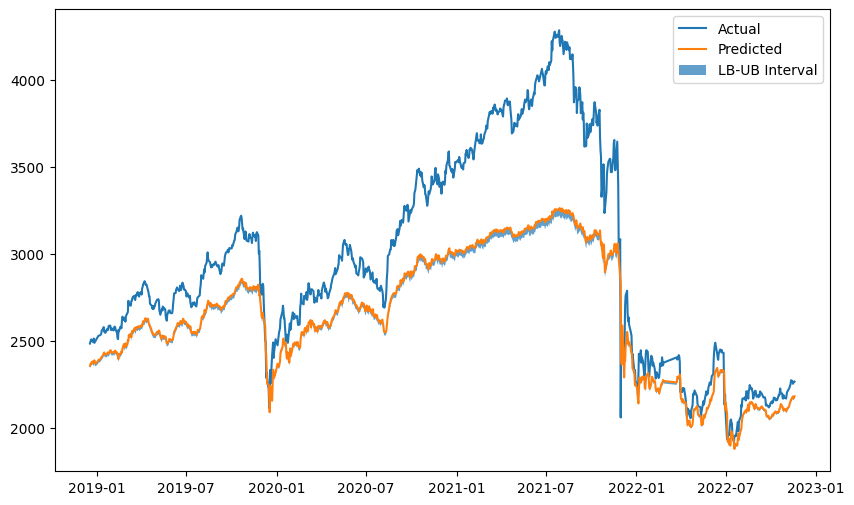

In [16]:
# Plot the actual and predicted stock prices with the upper and lower bounds
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(test['<DATE>'][:-forecast_horizon-60], y_test[:, 0], label='Actual')
ax.plot(test['<DATE>'][:-forecast_horizon-60], y_pred[:, 0], label='Predicted')
ax.fill_between(test['<DATE>'][:-forecast_horizon-60], y_pred[:, 0], y_pred[:, 1], alpha=0.7, label='LB-UB Interval')
ax.legend()
plt.show()


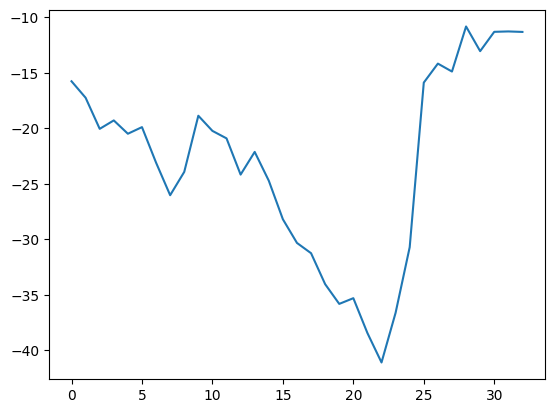

In [17]:
# the interval width
plt.plot(y_pred[::forecast_horizon, 1]-y_pred[::forecast_horizon, 0])

In [18]:
# Create the training data using the sliding window approach for all the data available
train_scaled = scaler.fit_transform(df['<CLOSE>'].values.reshape(-1, 1))

X_train = []
y_train = []
for i in range(window_size, len(train_scaled)):
    X_train.append(train_scaled[i-window_size:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)


In [19]:
model.fit(X_train, y_train, epochs=100, batch_size=32, callbacks=[early_stop])

Epoch 1/100
155/155 [==============================] - 16s 104ms/step - loss: 0.0207
Epoch 2/100
155/155 [==============================] - 16s 103ms/step - loss: 0.0194
Epoch 3/100
155/155 [==============================] - 17s 110ms/step - loss: 0.0187
Epoch 4/100
155/155 [==============================] - 16s 104ms/step - loss: 0.0175
Epoch 5/100
155/155 [==============================] - 17s 111ms/step - loss: 0.0183
Epoch 6/100
155/155 [==============================] - 16s 106ms/step - loss: 0.0185
Epoch 7/100
155/155 [==============================] - 17s 111ms/step - loss: 0.0170
Epoch 8/100
155/155 [==============================] - 17s 107ms/step - loss: 0.0178
Epoch 9/100
155/155 [==============================] - 16s 105ms/step - loss: 0.0169
Epoch 10/100
155/155 [==============================] - 17s 110ms/step - loss: 0.0178
Epoch 11/100
155/155 [==============================] - 17s 108ms/step - loss: 0.0164
Epoch 12/100
155/155 [==============================] - 16s 104

In [20]:
last_window_forecast = scaler.inverse_transform(model.predict(X_test[-window_size].reshape(-1,1)))

2/2 [==============================] - 2s 14ms/step


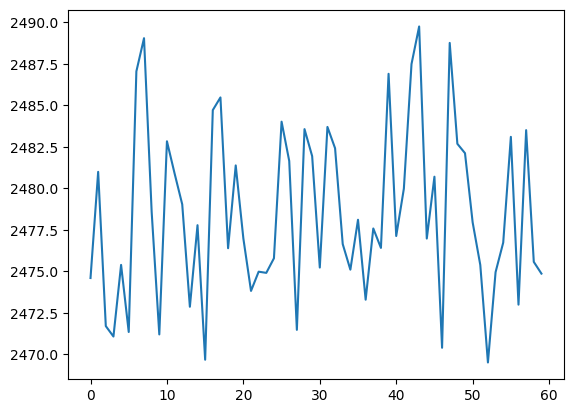

In [21]:
plt.plot(last_window_forecast[1])

In [22]:
import datetime

start_date = test['<DATE>'].iloc[-1].date()  # convert Timestamp to date object
N = 10  # replace with the number of dates you want to generate

dates = []
for i in range(N):
    date = start_date + datetime.timedelta(days=i)
    dates.append(date)

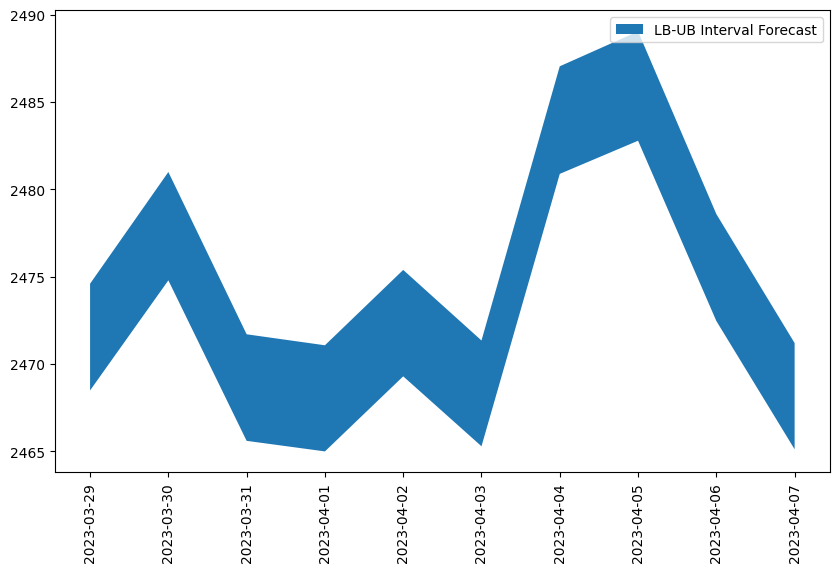

In [23]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.fill_between(dates, last_window_forecast[1,:N], last_window_forecast[0, :N], alpha=1, label='LB-UB Interval Forecast')
# rotate the x-axis tick labels
plt.xticks(rotation=90)
ax.legend()
plt.show()